In [97]:
import sympy as sp
import control as ct
import numpy as np

m1, m2, m3, k1, k2, k3, c1, c2, c3, F1, F2, F3 = sp.symbols('m1 m2 m3 k1 k2 k3 c1 c2 c3 F1 F2 F3')
s = sp.symbols('s')

F_eqn = sp.Matrix([
    [1, -1],
    [0, 1],
    [0, 0]
])
x_eqn = sp.Matrix([
    [m1 * s ** 2 + (c1 + c2) * s + (k1 + k2), -c2 * s - k2, 0],
    [-c2 * s - k2, m2 * s ** 2 + (c2 + c3) * s + (k2 + k3), -c3 * s - k3],
    [0, -c3 * s - k3, m3 * s ** 2 + c3 * s + k3]
])

full_tf = x_eqn.inv() @ F_eqn

In [98]:
subs_dict = {
    m1: 2,
    m2: 0.2,
    m3: 0.03,
    k1: 1e4,
    k2: 3e4,
    k3: 4e4,
    c1: 0.1,
    c2: 0.1,
    c3: 0.1,
}

Demonstrate that all elements are rational functions and the denominator is the same:

In [99]:
reference_denom = sp.collect(full_tf[0, 0], s).as_numer_denom()[1]
error = False

for elem_x in range(3):
    for elem_y in range(2):
        if not full_tf[elem_x, elem_y].is_rational_function:
            print(f"{elem_x=}, {elem_y=} is not rational")

        elem_denom = sp.collect(full_tf[elem_x, elem_y], s).as_numer_denom()[1]
        if elem_denom != reference_denom:
            print(f"{elem_x=}, {elem_y=} denominator is wrong")
            error=True

if not error:
    print("All denominators are the same")


All denominators are the same


Print out all the transfer functions as Latex, evaluated

In [122]:
print(f"Denominator:")
print(sp.latex(reference_denom.subs(subs_dict)))

for elem_x in range(3):
    for elem_y in range(2):
        numer = sp.collect(full_tf[elem_x, elem_y], s).as_numer_denom()[0]
        print(f"Numerator G{elem_x+1}{elem_y+1}:")
        print(sp.latex(numer.subs(subs_dict)))

Denominator:
0.012 s^{6} + 0.0532 s^{5} + 20440.0249 s^{4} + 16880.001 s^{3} + 2777000800.0 s^{2} + 190000000.0 s + 12000000000000.0
Numerator G11:
0.006 s^{4} + 0.026 s^{3} + 10100.01 s^{2} + 7000.0 s + 1200000000.0
Numerator G12:
- 0.006 s^{4} - 0.023 s^{3} - 9200.0 s^{2}
Numerator G21:
0.003 s^{3} + 900.01 s^{2} + 7000.0 s + 1200000000.0
Numerator G22:
0.06 s^{4} + 0.203 s^{3} + 80300.01 s^{2} + 5000.0 s + 400000000.0
Numerator G31:
0.01 s^{2} + 7000.0 s + 1200000000.0
Numerator G32:
0.2 s^{3} + 80000.01 s^{2} + 5000.0 s + 400000000.0


Convert into control TransferFunction - use Sympy to get everything in to polynomials for numerator + denominator:

In [100]:
numer, denom = sp.collect(full_tf[0, 0].subs(subs_dict), s).as_numer_denom()
numer.as_poly(s)

Poly(0.006*s**4 + 0.026*s**3 + 10100.01*s**2 + 7000.0*s + 1200000000.0, s, domain='RR')

In [101]:
numer.as_poly(s).all_coeffs() # in order of descending powers

[0.00600000000000000,
 0.0260000000000000,
 10100.0100000000,
 7000.00000000000,
 1200000000.00000]

In [ ]:
all_tfs = []
for elem_x in range(3):
    tfs_row = []
    for elem_y in range(2):
        numer, denom = sp.collect(full_tf[elem_x, elem_y].subs(subs_dict), s).as_numer_denom()
        numer_coeffs = [float(obj) for obj in numer.as_poly(s).all_coeffs()]
        denom_coeffs = [float(obj) for obj in denom.as_poly(s).all_coeffs()]

        tf = ct.TransferFunction(numer_coeffs, denom_coeffs)
        # print(f"Transfer Function G{elem_x+1}{elem_y+1}:\n{tf}\n")  
        tfs_row.append(tf)
    all_tfs.append(tfs_row)


Transfer Function G11:
<TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

                    0.006 s^4 + 0.026 s^3 + 1.01e+04 s^2 + 7000 s + 1.2e+09
  --------------------------------------------------------------------------------------------
  0.012 s^6 + 0.0532 s^5 + 2.044e+04 s^4 + 1.688e+04 s^3 + 2.777e+09 s^2 + 1.9e+08 s + 1.2e+13

Transfer Function G12:
<TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

                               -0.006 s^4 - 0.023 s^3 - 9200 s^2
  --------------------------------------------------------------------------------------------
  0.012 s^6 + 0.0532 s^5 + 2.044e+04 s^4 + 1.688e+04 s^3 + 2.777e+09 s^2 + 1.9e+08 s + 1.2e+13

Transfer Function G21:
<TransferFunction>: sys[7]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

                             0.003 s^3 + 900 s^2 + 7000 s + 1.2e+09
  --------------------------------------------------------------------------------------------
  0.012 s^6 + 0.0532 s^5 + 2.044

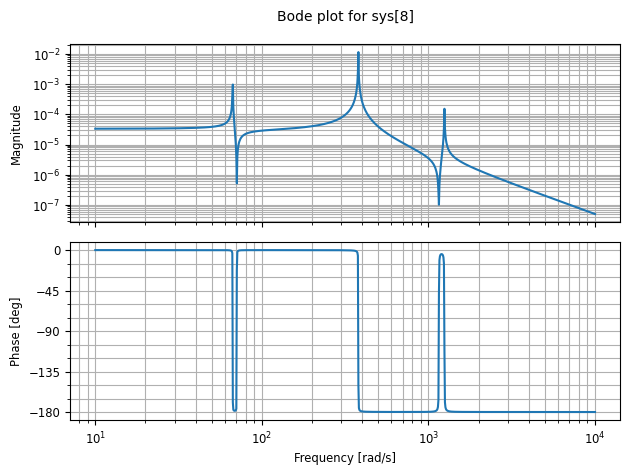

In [123]:
ct.bode(all_tfs[1][1])